In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ecephys import xrsig
import ecephys.plot as eplt
import ecephys_analyses as ea

import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
xr.set_options(keep_attrs=True)

In [3]:
subject = "Charles"
experiment = "sleep_homeostasis"
alias = "circadian_match"
probe = "imec1"
bin_paths = ea.get_lfp_bin_paths(subject, experiment, alias, probe=probe)

In [4]:
spg_paths = ea.get_analysis_counterparts(bin_paths, "spg.nc", subject)
spg = ea.load.load_and_concatenate_datasets(spg_paths)

In [5]:
bp_paths = ea.get_analysis_counterparts(bin_paths, "bandpower.nc", subject)
bp = ea.load.load_and_concatenate_datasets(bp_paths)

In [6]:
hg = ea.load.load_hypnogram(subject, experiment, alias, probe)

In [7]:
LIGHTS_ON = "09:00:00"
LIGHTS_OFF = "21:00:00"

hg_light = hg.keep_between(LIGHTS_ON, LIGHTS_OFF)
hg_dark = hg.keep_between(LIGHTS_OFF, LIGHTS_ON)

In [8]:
def smooth_and_crop(pwr, hg, smoothing):
    return pwr.rolling(time=smoothing, center=True).mean().where(hg.covers_time(pwr.datetime)).dropna(dim="time").swap_dims({"time": "datetime"}).drop_vars(["time", "timedelta"])

In [9]:
def plot_spectrogram_with_bandpower(spg, bp, hg, title=None, figsize=(32, 5)):
    #wake = 'silver'
    #nrem = 'dodgerblue'
    #rem = 'orangered'
    
    wake = 'white'
    nrem = 'lightskyblue'
    rem = 'orangered'
    
    #wake = 'white'
    #nrem = 'darkgrey'
    #rem = 'orangered'
    
    state_colors = {
        "Wake": wake,
        "Arousal": nrem,
        "Trans": nrem,
        "N1": nrem,
        "N2": nrem,
        "IS": rem,
        "REM": rem,
        "Art": "crimson",
        "None": "white",
    }
    
    fig, (bp_ax, spg_ax) = plt.subplots(ncols=1, nrows=2, figsize=figsize, gridspec_kw=dict(width_ratios=[1], height_ratios=[1, 1]))
    
    sns.lineplot(x=bp.datetime.values, y=bp.values, color='black', ax=bp_ax)
    bp_ax.set(xlabel=None, ylabel="Delta [uV^2/Hz]", xticks=[], xmargin=0)
    
    eplt.plot_spectrogram(spg.frequency.values, spg.datetime.values, spg.values, yscale="linear", f_range=(0, 20), ax=spg_ax)

    eplt.plot_hypnogram_overlay(hg, state_colors=state_colors, ax=bp_ax)
    
    if title:
        fig.suptitle(title)
    plt.tight_layout(h_pad=0.0)

In [10]:
SMOOTHING = 20

In [11]:
spg_light = smooth_and_crop(spg, hg_light, SMOOTHING)
bp_light = smooth_and_crop(bp, hg_light, SMOOTHING)

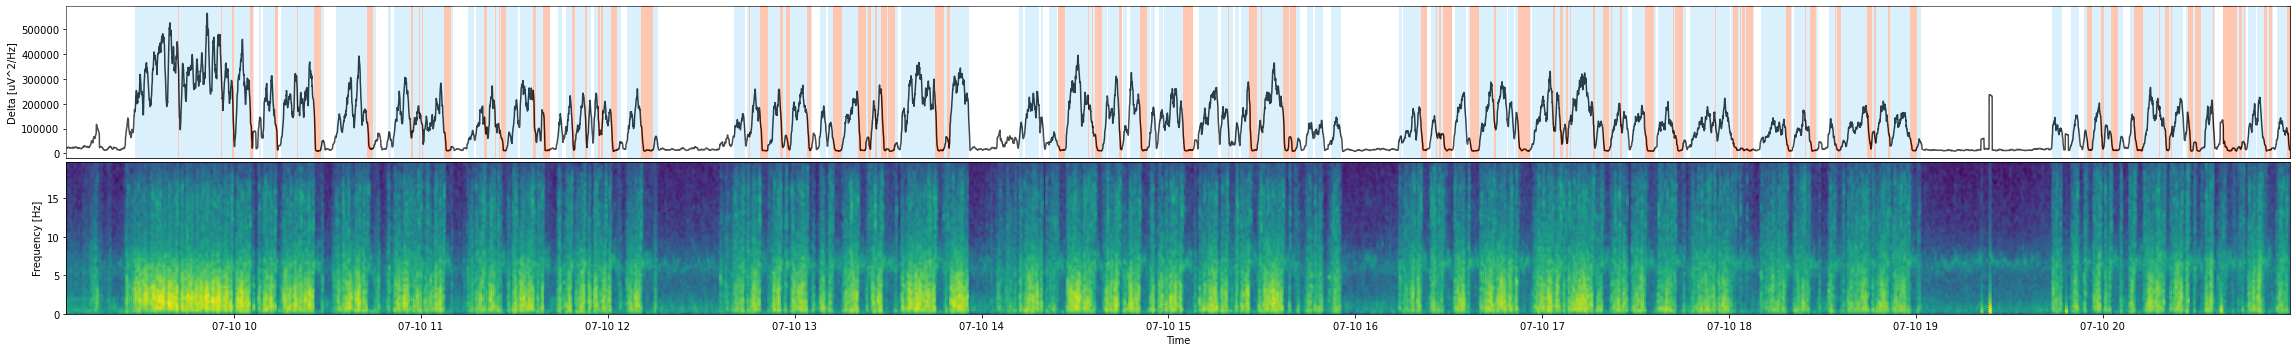

In [12]:
plot_spectrogram_with_bandpower(spg_light.mpta_wm_ref, bp_light.mpta_delta_wm_ref, hg_light)

In [13]:
spg_dark = smooth_and_crop(spg, hg_dark, SMOOTHING)
bp_dark = smooth_and_crop(bp, hg_dark, SMOOTHING)

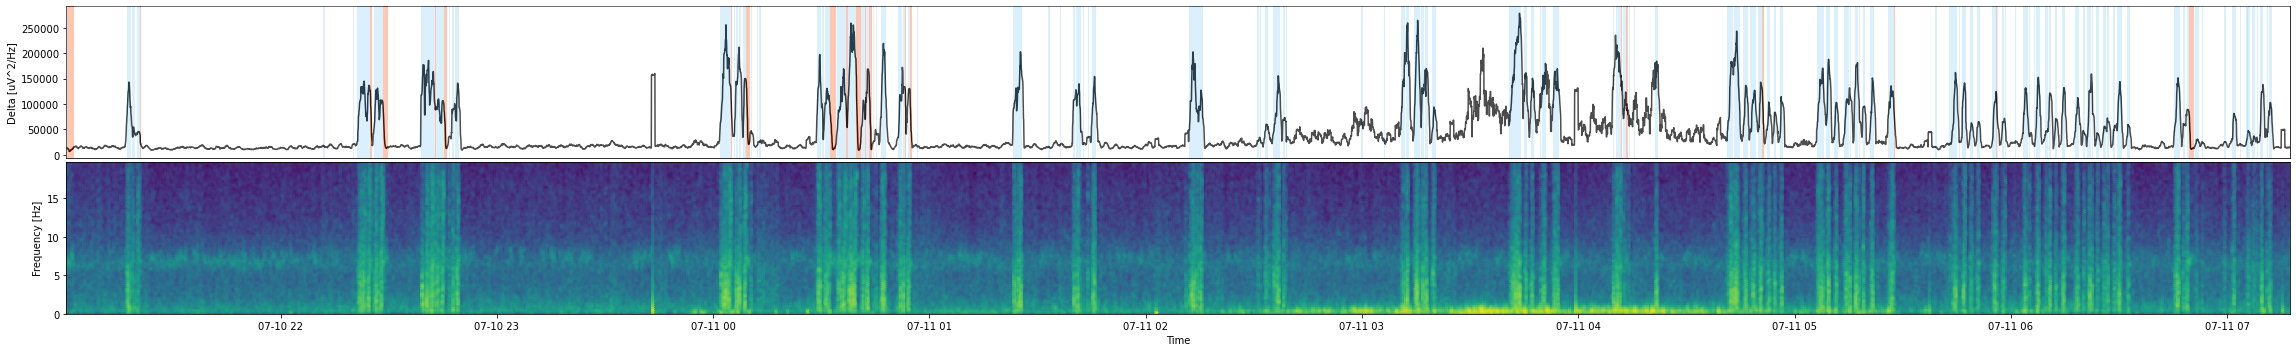

In [14]:
plot_spectrogram_with_bandpower(spg_dark.mpta_wm_ref, bp_dark.mpta_delta_wm_ref, hg_dark)